In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Dataset

## Produzione di energia elettrica

I dati sulla produzione di energia elettrica sono tratti dal sito web della BP sezione “Energy economics; Statistical review of world energy”.
https://www.bp.com/en/global/corporate/energy-economics/statistical-review-of-world-energy.html

### Pulizia del dataset

Il dataset viene filtrato prendendo in considerazione solo le colonne relative alla produzione di energia elettrica ed eliminando le somme parziali (che nel dataset sono quelle righe in cui 'Country' contiene la parola 'Total', per esempio 'Total Europa', 'Total Africa', ecc...). Dopo di che vengono presi i dati a partire dal 1985 e viene fatto il renaming di alcuni attributi.

In [2]:
production_data_with_totals = pd.read_csv('data/bp-stats-review-2022-consolidated-dataset-panel-format.csv')
production_data = production_data_with_totals[~((production_data_with_totals['Country'].str.contains('Total')) | (production_data_with_totals['Region'].str.contains('Total')) | (production_data_with_totals['SubRegion'].str.contains('Total')))]
production_data = production_data[['ISO3166_alpha3',
                                   'Country',
                                   'Year',
                                   'pop',
                                   'EU',
                                   'Region',
                                   'SubRegion',
                                   'electbyfuel_coal',
                                   'electbyfuel_gas', 
                                   'electbyfuel_hydro', 
                                   'electbyfuel_nuclear', 
                                   'electbyfuel_oil', 
                                   'electbyfuel_other', 
                                   'electbyfuel_ren_power', 
                                   'electbyfuel_total']]
production_data = production_data[production_data['Year'] >= 1985]
production_data = production_data.rename(columns={
    'ISO3166_alpha3': 'ISO',
    'pop': 'Pop',
    'electbyfuel_coal': 'ElectBy_Coal',
    'electbyfuel_gas': 'ElectBy_Gas',
    'electbyfuel_hydro': 'ElectBy_Hydro',
    'electbyfuel_nuclear': 'ElectBy_Nuclear',
    'electbyfuel_oil': 'ElectBy_Oil',
    'electbyfuel_other': 'ElectBy_Other',
    'electbyfuel_ren_power': 'ElectBy_NewRenewables',
    'electbyfuel_total': 'Total_ElectProd'
})
production_data[(production_data['ISO'] == 'ITA') & (production_data['Year'] >= 2019)]


,ISO,Country,Year,Pop,EU,Region,SubRegion,ElectBy_Coal,ElectBy_Gas,ElectBy_Hydro,ElectBy_Nuclear,ElectBy_Oil,ElectBy_Other,ElectBy_NewRenewables,Total_ElectProd
2328,ITA,Italy,2019,59.91075,1.0,Europe,Europe,21.291300,141.687000,47.154800,NaN,11.822400,2.536900,69.360800,293.853200
2329,ITA,Italy,2020,59.48365,1.0,Europe,Europe,15.076100,133.682800,45.728624,NaN,11.439900,5.789642,68.813934,280.531000
2330,ITA,Italy,2021,59.26080,1.0,Europe,Europe,14.523271,146.418501,43.056321,NaN,8.274411,3.489428,71.441345,287.203277


## Emissioni di CO2

I dati sulle emissioni di CO2 sono tratti dal sito web della Commissione Europea EDGAR (Emission database for global atmospheric research) sezione “CO2 and GHG Emission reports”.
https://edgar.jrc.ec.europa.eu/report_2022#data_download

### Pulizia ed elaborazione del dataset

In [3]:
emission_data = pd.read_csv('data/fossil_CO2_by_sector_and_country.csv')
emission_data[emission_data['EDGAR Country Code'] == 'ITA'].head(3)


,Substance,Sector,EDGAR Country Code,Country,1970,1971,1972,1973,1974,1975,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
94,CO2,Power Industry,ITA,"Italy, San Marino and the Holy See",51.622832,57.961169,62.486951,71.999922,74.770119,71.005236,...,129.342344,111.189778,103.416525,108.936510,108.253157,109.067937,101.122366,96.299693,86.516061,92.997436
300,CO2,Buildings,ITA,"Italy, San Marino and the Holy See",66.959557,72.590422,78.507695,80.068526,79.235537,79.742923,...,76.819108,76.150034,64.899388,70.911294,71.104044,70.758140,71.298729,68.762820,63.886392,68.976266
508,CO2,Transport,ITA,"Italy, San Marino and the Holy See",46.219192,48.167830,51.436468,55.229348,51.825451,54.974965,...,102.511045,100.723344,105.392849,103.008501,101.711254,97.611058,100.202582,100.918684,82.667374,92.101010


Per uniformare i dataset è stato necessario riorganizzare i dati in modo che ogni riga rappresenti un singolo anno di dati sulle emissioni per un singolo paese, settore e sostanza. Questo è stato fatto tramite la funzione melt. 

In [4]:
emission_data = emission_data.melt(id_vars=['Substance', 'Sector', 'EDGAR Country Code', 'Country'], var_name='Year', value_name='emissions')
emission_data['Year'] = emission_data['Year'].astype(int)
emission_data = emission_data[['EDGAR Country Code', 
                               'Country',
                               'Year',
                               'Substance',
                               'Sector', 
                               'emissions']]
emission_data = emission_data[emission_data['Year'] >= 1985]
emission_data = emission_data.rename(columns={
    'EDGAR Country Code': 'ISO', 
    'emissions': 'Emissions'
})
emission_data[(emission_data['ISO'] == 'ITA') & (emission_data['Year'] == 2021)]


,ISO,Country,Year,Substance,Sector,Emissions
52930,ITA,"Italy, San Marino and the Holy See",2021,CO2,Power Industry,92.997436
53136,ITA,"Italy, San Marino and the Holy See",2021,CO2,Buildings,68.976266
53344,ITA,"Italy, San Marino and the Holy See",2021,CO2,Transport,92.101010
53551,ITA,"Italy, San Marino and the Holy See",2021,CO2,Other industrial combustion,42.155571
53759,ITA,"Italy, San Marino and the Holy See",2021,CO2,Other sectors,23.438728


## Unione dei dataset

Per unire i dataset, è stato eseguito un merge. Prima di procedere con l'unione, sono stati effettuati diversi passaggi di trasformazione e aggregazione sui dati. Inizialmente, i dati sono stati raggruppati per 'ISO', 'Year' e 'Sector', sommando le emissioni di CO2 per ciascun gruppo. Successivamente, è stata creata una pivot table per trasformare il formato dei dati, ottenendo ogni settore come una colonna separata. Le colonne sono state rinominate per migliorare la comprensione dei dati e, inoltre, è stata calcolata la somma totale delle emissioni di CO2 per ciascuna riga, sommando le emissioni di tutti i settori. Infine, i due dataset sono stati uniti sulla base delle colonne 'ISO' e 'Year', mantenendo tutte le righe del dataset sulla produzione di energia elettrica e unendo i dati sulle emissioni di CO2 corrispondenti, se disponibili.

In [5]:
emission_data_grouped = emission_data.groupby(['ISO', 'Year', 'Sector']).sum().reset_index()

emission_data_wide = emission_data_grouped.pivot_table(index=['ISO', 'Year'], columns='Sector', values='Emissions').reset_index()

emission_data_wide.columns = ['ISO', 'Year', 'CO2By_Buildings', 'CO2By_OtherCombustion', 'CO2By_OtherSectors', 'CO2By_ElectProd', 'CO2By_Transport']

emission_data_wide['Total_CO2'] = emission_data_wide[['CO2By_Buildings', 'CO2By_ElectProd', 'CO2By_OtherCombustion', 'CO2By_OtherSectors', 'CO2By_Transport']].sum(axis=1)

merged_data = pd.merge(production_data, emission_data_wide, on=['ISO', 'Year'], how='left')

merged_data[(merged_data['ISO'] == 'ITA') & (merged_data['Year'] >= 2019)]


,ISO,Country,Year,Pop,EU,Region,SubRegion,ElectBy_Coal,ElectBy_Gas,ElectBy_Hydro,...,ElectBy_Oil,ElectBy_Other,ElectBy_NewRenewables,Total_ElectProd,CO2By_Buildings,CO2By_OtherCombustion,CO2By_OtherSectors,CO2By_ElectProd,CO2By_Transport,Total_CO2
1604,ITA,Italy,2019,59.91075,1.0,Europe,Europe,21.291300,141.687000,47.154800,...,11.822400,2.536900,69.360800,293.853200,68.762820,43.336105,25.120257,96.299693,100.918684,334.437560
1605,ITA,Italy,2020,59.48365,1.0,Europe,Europe,15.076100,133.682800,45.728624,...,11.439900,5.789642,68.813934,280.531000,63.886392,38.939206,23.410041,86.516061,82.667374,295.419074
1606,ITA,Italy,2021,59.26080,1.0,Europe,Europe,14.523271,146.418501,43.056321,...,8.274411,3.489428,71.441345,287.203277,68.976266,42.155571,23.438728,92.997436,92.101010,319.669011


# Grafici

## Mondo (Produzione di energia elettrica)

### Produzione mondiale lorda di energia elettrica per fonte in assoluto (TWh)

[Descrizione]

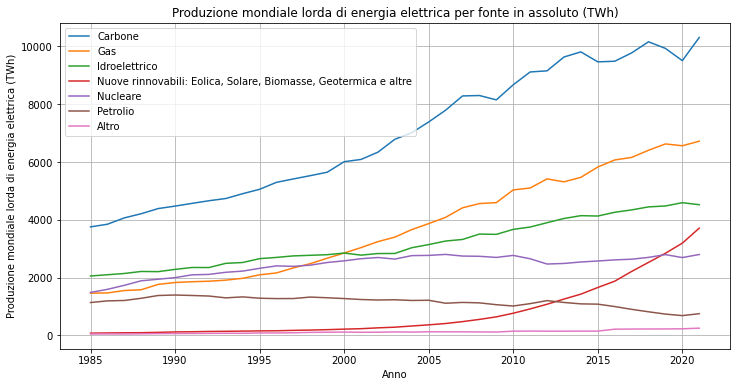

In [6]:
grouped_data = production_data.groupby('Year')[['ElectBy_Coal', 'ElectBy_Gas', 'ElectBy_Hydro', 'ElectBy_Nuclear', 'ElectBy_Oil', 'ElectBy_Other', 'ElectBy_NewRenewables']].sum()

plt.figure(figsize=(12, 6))
plt.plot(grouped_data.index, grouped_data['ElectBy_Coal'], label='Carbone')
plt.plot(grouped_data.index, grouped_data['ElectBy_Gas'], label='Gas')
plt.plot(grouped_data.index, grouped_data['ElectBy_Hydro'], label='Idroelettrico')
plt.plot(grouped_data.index, grouped_data['ElectBy_NewRenewables'], label='Nuove rinnovabili: Eolica, Solare, Biomasse, Geotermica e altre')
plt.plot(grouped_data.index, grouped_data['ElectBy_Nuclear'], label='Nucleare')
plt.plot(grouped_data.index, grouped_data['ElectBy_Oil'], label='Petrolio')
plt.plot(grouped_data.index, grouped_data['ElectBy_Other'], label='Altro')

plt.xlabel('Anno')
plt.ylabel('Produzione mondiale lorda di energia elettrica (TWh)')
plt.title('Produzione mondiale lorda di energia elettrica per fonte in assoluto (TWh)')
plt.legend()
plt.grid()
plt.show()

### Produzione mondiale lorda di energia elettrica per fonte in percentuale (%)

[Descrizione]

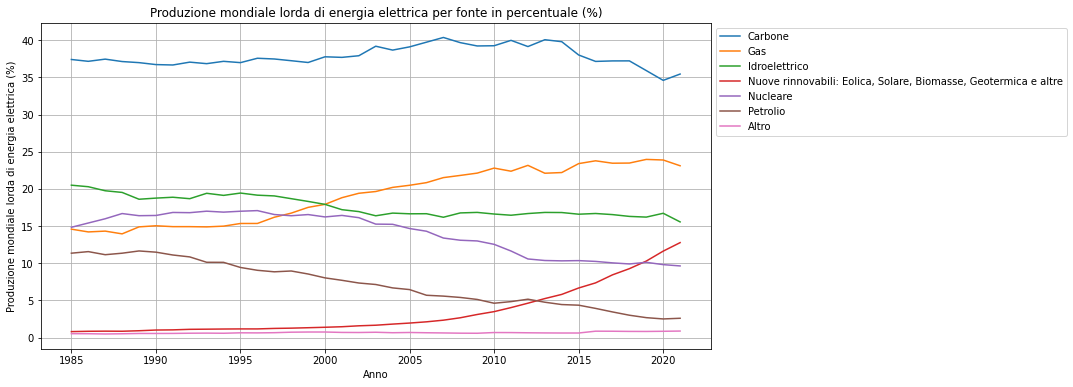

In [7]:
grouped_data = production_data.groupby('Year')[['ElectBy_Coal', 'ElectBy_Gas', 'ElectBy_Hydro', 'ElectBy_Nuclear', 'ElectBy_Oil', 'ElectBy_Other', 'ElectBy_NewRenewables']].sum()
grouped_data_percentage = grouped_data.divide(grouped_data.sum(axis=1), axis=0) * 100

plt.figure(figsize=(12, 6))
plt.plot(grouped_data_percentage.index, grouped_data_percentage['ElectBy_Coal'], label='Carbone')
plt.plot(grouped_data_percentage.index, grouped_data_percentage['ElectBy_Gas'], label='Gas')
plt.plot(grouped_data_percentage.index, grouped_data_percentage['ElectBy_Hydro'], label='Idroelettrico')
plt.plot(grouped_data_percentage.index, grouped_data_percentage['ElectBy_NewRenewables'], label='Nuove rinnovabili: Eolica, Solare, Biomasse, Geotermica e altre')
plt.plot(grouped_data_percentage.index, grouped_data_percentage['ElectBy_Nuclear'], label='Nucleare')
plt.plot(grouped_data_percentage.index, grouped_data_percentage['ElectBy_Oil'], label='Petrolio')
plt.plot(grouped_data_percentage.index, grouped_data_percentage['ElectBy_Other'], label='Altro')

plt.xlabel('Anno')
plt.ylabel('Produzione mondiale lorda di energia elettrica (%)')
plt.title('Produzione mondiale lorda di energia elettrica per fonte in percentuale (%)')
plt.legend(bbox_to_anchor=(1, 1))
plt.grid()
plt.show()


[Descrizione]

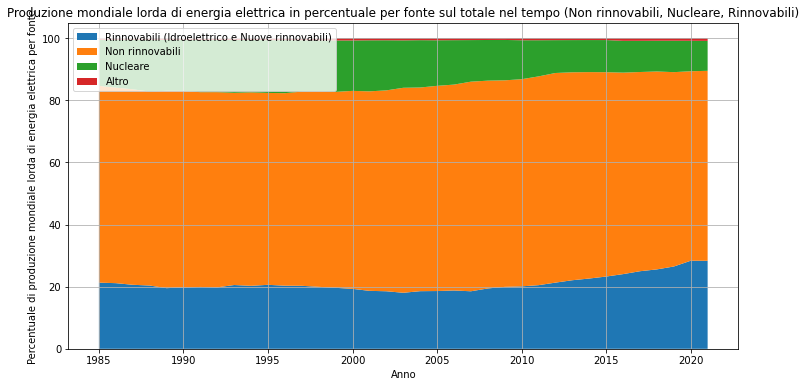

In [8]:
grouped_data = production_data.groupby('Year')[['ElectBy_Coal', 'ElectBy_Gas', 'ElectBy_Hydro', 'ElectBy_Nuclear', 'ElectBy_Oil', 'ElectBy_Other', 'ElectBy_NewRenewables']].sum()
grouped_data_percentage = grouped_data.divide(grouped_data.sum(axis=1), axis=0) * 100

grouped_data_percentage['NotRenewable'] = grouped_data_percentage['ElectBy_Coal'] + grouped_data_percentage['ElectBy_Gas'] + grouped_data_percentage['ElectBy_Oil']
grouped_data_percentage['Nuclear'] = grouped_data_percentage['ElectBy_Nuclear']
grouped_data_percentage['Other'] = grouped_data_percentage['ElectBy_Other']
grouped_data_percentage['Renewable'] = grouped_data_percentage['ElectBy_Hydro'] + grouped_data_percentage['ElectBy_NewRenewables']

plt.figure(figsize=(12, 6))

x = grouped_data_percentage.index
y = [grouped_data_percentage['Renewable'],
     grouped_data_percentage['NotRenewable'],
     grouped_data_percentage['Nuclear'],
     grouped_data_percentage['Other']]

labels = ['Rinnovabili (Idroelettrico e Nuove rinnovabili)', 'Non rinnovabili', 'Nucleare', 'Altro']

plt.stackplot(x, y, labels=labels)

plt.xlabel('Anno')
plt.ylabel('Percentuale di produzione mondiale lorda di energia elettrica per fonte')
plt.title('Produzione mondiale lorda di energia elettrica in percentuale per fonte sul totale nel tempo (Non rinnovabili, Nucleare, Rinnovabili)')
plt.legend(loc='upper left')
plt.grid()
plt.show()


### Produzione mondiale lorda di energia elettrica per area geografica in assoluto (TWh)

[Descrizione]

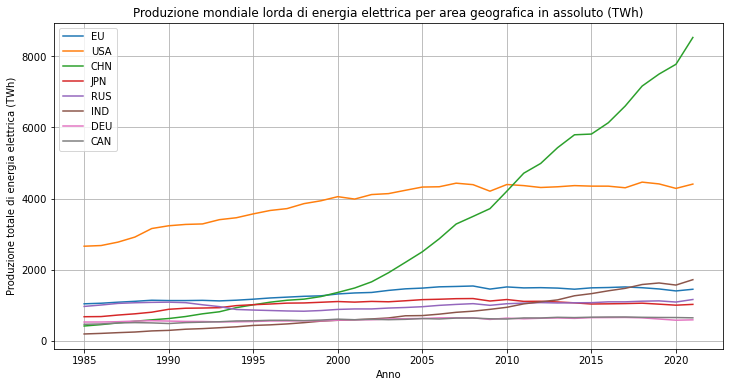

In [9]:
eu_data = production_data[production_data['ISO'].isin(['BEL', 'BGR', 'CZE', 'DNK', 'DEU', 'EST', 'IRL', 'GRC', 'ESP', 'FRA', 'HRV', 'ITA', 'CYP', 'LVA', 'LTU', 'LUX', 'HUN', 'MLT', 'NLD', 'AUT', 'POL', 'PRT', 'ROU', 'SVN', 'SVK', 'FIN', 'SWE'])]
eu_data = eu_data.groupby('Year')['Total_ElectProd'].sum()

countries = ['USA', 'CHN', 'JPN', 'RUS', 'IND', 'DEU', 'CAN']

plt.figure(figsize=(12, 6))

plt.plot(eu_data.index, eu_data, label='EU')

for country in countries:
    data = production_data[production_data['ISO'] == country].groupby('Year')['Total_ElectProd'].sum()
    plt.plot(data.index, data, label=country)

plt.xlabel('Anno')
plt.ylabel('Produzione totale di energia elettrica (TWh)')
plt.title('Produzione mondiale lorda di energia elettrica per area geografica in assoluto (TWh)')
plt.legend()
plt.grid()
plt.show()

## Europa (Produzione di energia elettrica)

### Produzione europea lorda di energia elettrica per fonte in assoluto (TWh)

[Descrizione]

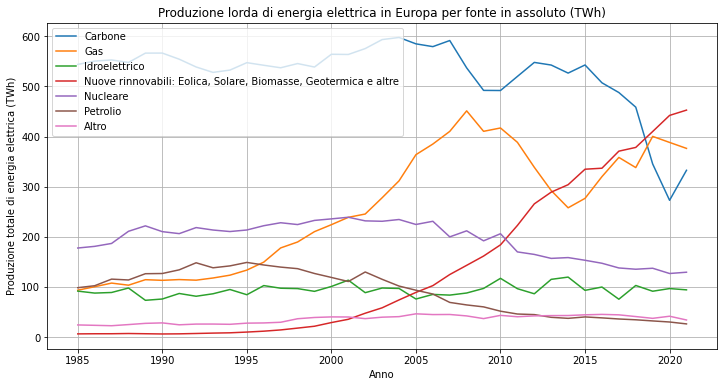

In [10]:
eu_data = production_data[production_data['ISO'].isin(['BEL', 'BGR', 'CZE', 'DNK', 'DEU', 'EST', 'IRL', 'GRC', 'ESP', 'FRA', 'HRV', 'ITA', 'CYP', 'LVA', 'LTU', 'LUX', 'HUN', 'MLT', 'NLD', 'AUT', 'POL', 'PRT', 'ROU', 'SVN', 'SVK', 'FIN', 'SWE'])]
grouped_data = eu_data.groupby('Year')[['ElectBy_Coal', 'ElectBy_Gas', 'ElectBy_Hydro', 'ElectBy_Nuclear', 'ElectBy_Oil', 'ElectBy_Other', 'ElectBy_NewRenewables']].sum()

plt.figure(figsize=(12, 6))
plt.plot(grouped_data.index, grouped_data['ElectBy_Coal'], label='Carbone')
plt.plot(grouped_data.index, grouped_data['ElectBy_Gas'], label='Gas')
plt.plot(grouped_data.index, grouped_data['ElectBy_Hydro'], label='Idroelettrico')
plt.plot(grouped_data.index, grouped_data['ElectBy_NewRenewables'], label='Nuove rinnovabili: Eolica, Solare, Biomasse, Geotermica e altre')
plt.plot(grouped_data.index, grouped_data['ElectBy_Nuclear'], label='Nucleare')
plt.plot(grouped_data.index, grouped_data['ElectBy_Oil'], label='Petrolio')
plt.plot(grouped_data.index, grouped_data['ElectBy_Other'], label='Altro')

plt.xlabel('Anno')
plt.ylabel('Produzione totale di energia elettrica (TWh)')
plt.title('Produzione lorda di energia elettrica in Europa per fonte in assoluto (TWh)')
plt.legend()
plt.grid()
plt.show()


### Produzione europea lorda di energia elettrica per fonte in percentuale (%)

[Descrizione]

In [11]:
# Line chart(Tutte le fonti)

[Descrizione]

In [12]:
# Area chart (Non rinnovabili, Rinnovabili, Nucleare, Altro)

### Energia elettrica prodotta per stato in assoluto negli ultimi 10 anni (TWh)

[Descrizione]

In [13]:
# Word cloud

## Italia (Produzione di energia elettrica)

### Produzione lorda di energia elettrica per fonte in assoluto negli ultimi 10 anni (TWh)

[Descrizione]

In [14]:
# Bar chart

### Produzione lorda di energia elettrica per categoria in percentuale negli ultimi 10 anni (%)

In [15]:
# Pie chart (Non rinnovabili, Rinnovabili, Nucleare, Altro)

## Confronto

### Confronto percentuali per fonte per Mondo, Unione Europea, Italia, Stati Uniti e Cina

[Descrizione]

In [16]:
# Line chart (Non rinnovabili, Rinnovabili, Nucleare)

## Emissioni per settore

[Descrizione]

In [17]:
# TreeMap

### Box plot per le emissioni (1991, 2001, 2011, 2021)

[Descrizione]

In [18]:
# Box plot

### Emissioni di CO2 (Power Industry) per paese 

[Descrizione]

In [19]:
# Line chart

### Emissioni di CO2 (Power Industry) nel 2021

[Descrizione]

In [20]:
# Pie chart a livelli

### Relazione tra Energia elettrica prodotta ed emissioni della power industry 

[Descrizione]

In [21]:
# Scatter Plot